In [18]:
import math
import torch
import os
import random
import re
import requests
import zipfile
import hashlib
import collections

import sys

This dataset has already been preprocessed. Each line of the dataset acts as a sentence. All the words in a sentence are separated by spaces. In the word embedding task, each word is a token.

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
def read_ptb():
    with open(os.path.join(sys.path[0], "ptb.train.txt"), "r") as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]


sentences = read_ptb() # list of list of words
f'# sentences: {len(sentences)}'

'# sentences: 42069'

In [24]:
### Creating vocabulary

def tokenize(lines, token='word'):
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)
        
class Vocab:  #@save
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The index for the unknown token is 0
        self.unk, uniq_tokens = 0, ['<unk>'] + reserved_tokens
        uniq_tokens += [token for token, freq in self.token_freqs
                        if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

def count_corpus(tokens):  #@save
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [26]:
vocab = Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

In [28]:
## Subsampling ('a','the',....)

# Specifically, each indexed word  wi  in the dataset will drop out at a certain probability.
# The dropout probability is given as: max(1-t/f(w_i),0)
# f(w_i) is ratio of instances word w_i to total number of words
# t is Hyperparameter

In [32]:
def subsampling(sentences, vocab):
    # Map low frequency words into <unk>
    sentences = [[vocab.idx_to_token[vocab[tk]] for tk in line]
                 for line in sentences]
#     print(sentences[1])
    # Count the frequency for each word
    counter = count_corpus(sentences)
    num_tokens = sum(counter.values())

    # Return True if to keep this token during subsampling
    def keep(token):
        return(random.uniform(0, 1) <
               math.sqrt(1e-4 / counter[token] * num_tokens))

    # Now do the subsampling
    return [[tk for tk in line if keep(tk)] for line in sentences]

subsampled = subsampling(sentences, vocab)
# subsampled

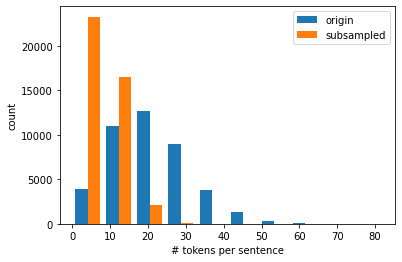

In [34]:
import matplotlib.pyplot as plt

# set_figsize()
plt.hist([[len(line) for line in sentences],
              [len(line) for line in subsampled]])
plt.xlabel('# tokens per sentence')
plt.ylabel('count')
plt.legend(['origin', 'subsampled']);

In [35]:
def compare_counts(token):
    return (f'# of "{token}": '
            f'before={sum([line.count(token) for line in sentences])}, '
            f'after={sum([line.count(token) for line in subsampled])}')

compare_counts('the')

'# of "the": before=50770, after=2023'

In [36]:
compare_counts('join')

'# of "join": before=45, after=45'

In [39]:
# construct corpus

corpus = [vocab[line] for line in subsampled]
corpus[1]

[392, 2115, 406]

In [46]:
def get_centers_and_contexts(corpus, max_window_size):
    centers, contexts = [], []
    for line in corpus:
        # Each sentence needs at least 2 words to form a "central target word
        # - context word" pair
        if len(line) < 2:
            continue
#         print(line,"hi")
        centers += line
        for i in range(len(line)):  # Context window centered at i
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # Exclude the central target word from the context words
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

In [47]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('dataset', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('center', center, 'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1, 2]
center 1 has contexts [0, 2]
center 2 has contexts [0, 1, 3, 4]
center 3 has contexts [2, 4]
center 4 has contexts [3, 5]
center 5 has contexts [4, 6]
center 6 has contexts [5]
center 7 has contexts [8, 9]
center 8 has contexts [7, 9]
center 9 has contexts [8]


In [48]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# center-context pairs: {len(all_centers)}'

'# center-context pairs: 352566'

In [49]:
## Negative sampling

class RandomGenerator:
    """Draw a random int in [0, n] according to n sampling weights."""
    def __init__(self, sampling_weights):
        self.population = list(range(len(sampling_weights)))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i-1]

generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[1, 1, 2, 2, 2, 2, 2, 1, 1, 1]

In [67]:
def get_negatives(all_contexts, corpus, K):
    counter = count_corpus(corpus)
    sampling_weights = [counter[i]**0.75 for i in range(len(counter))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
#         print(context)
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise words cannot be context words
#             print(neg)
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
#         print(len(contexts),len(negatives))      
    return all_negatives

all_negatives = get_negatives(all_contexts, corpus, 5)

In [74]:
def batchify(data):
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape(
        (-1, 1)), torch.tensor(contexts_negatives), torch.tensor(masks),
            torch.tensor(labels))

In [73]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


In [75]:
batch_size = 512

class PTBDataset(torch.utils.data.Dataset):
    def __init__(self, centers, contexts, negatives):
        assert len(centers) == len(contexts) == len(negatives)
        self.centers = centers
        self.contexts = contexts
        self.negatives = negatives

    def __getitem__(self, index):
        return (self.centers[index], self.contexts[index], self.negatives[index])

    def __len__(self):
        return len(self.centers)
    
dataset = PTBDataset(
    all_centers, all_contexts, all_negatives)

data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                  collate_fn=batchify,
                                  num_workers=0)

In [76]:
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


In [77]:
### Training

In [78]:
from torch import nn

In [79]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}, '
      'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype={embed.weight.dtype})


In [83]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

In [84]:
skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

In [85]:
class SigmoidBCELoss(nn.Module):
    "BCEWithLogitLoss with masking on call."
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

In [115]:
embed_size = 50
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size))

In [116]:
device

device(type='cuda', index=0)

In [117]:
def train(net, data_iter, lr, num_epochs):
    def init_weights(m):
        if type(m) == nn.Embedding:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    metric = []
    for epoch in range(num_epochs):
        print(epoch)
        num_batches =  len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]
            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.append(l.sum())

In [118]:
lr, num_epochs = 0.01, 6
train(net, data_iter, lr, num_epochs)

0
1
2
3
4
5


In [119]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # Remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.idx_to_token[i]}')

get_similar_tokens('chips', 3, net[0])

cosine sim=0.660: memory
cosine sim=0.648: faster
cosine sim=0.554: disks
